# Introduction

- A project to build a simple token-level bigram model to write a ML research paper in the style of 15 scraped Arxiv papers in Computer Linguistics.
- Based on Andrej Karpathy's excellent series: https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

### Load libraries

In [79]:
from transformers import LlamaTokenizer
import torch
import matplotlib.pyplot as plt
import glob
import os

### Create tokenizer

In [31]:
model_path = 'openlm-research/open_llama_3b_v2'
tokenizer = LlamaTokenizer.from_pretrained(model_path)

print(tokenizer.vocab_size)

32000


### Load and encode text to tokens

In [87]:
PATH = "../../RAG-ML-chatbot/data/txt/content/cs_CL/"
data = []
for paper in glob.glob(os.path.join(PATH, "*.txt")):
    with open(paper, "r") as f:
        data.append(f.read())

data = "\n".join(data)

In [89]:
tokens = tokenizer(data).input_ids
#tokens = torch.tensor(tokenizer(data).input_ids)

In [91]:
print(f"there are {len(data)} characters in the ML papers")
print(f"there are {len(tokens)} tokens in the ML papers")
print(f"there are {len(set(tokens))} unique tokens in the ML papers")

there are 795720 characters in the ML papers
there are 207726 tokens in the ML papers
there are 10604 unique tokens in the ML papers


### Compute token bigram statistics

In [92]:
N = torch.zeros((tokenizer.vocab_size, tokenizer.vocab_size), dtype=torch.int32)

In [93]:
for t1, t2 in zip(tokens, tokens[1:]):
    N[t1-1, t2-1] += 1

In [217]:
# compute token bigram frequencies
sorted, indices = torch.sort(torch.flatten(N), descending=True)

# get indices of token bigrams
idx = []
for x in sorted[:40]:
    idx.append((N == x).nonzero(as_tuple=True))
    
# get decoded token bigrams
b = []
for tok1, tok2 in idx:
    if len(tok1)==1:
        b.append(tokenizer.decode(tok1.item())+"//"+tokenizer.decode(tok2.item()))
    else:
        for t1, t2 in zip(tok1, tok2):
            b.append(tokenizer.decode(t1.item())+"//"+tokenizer.decode(t2.item()))

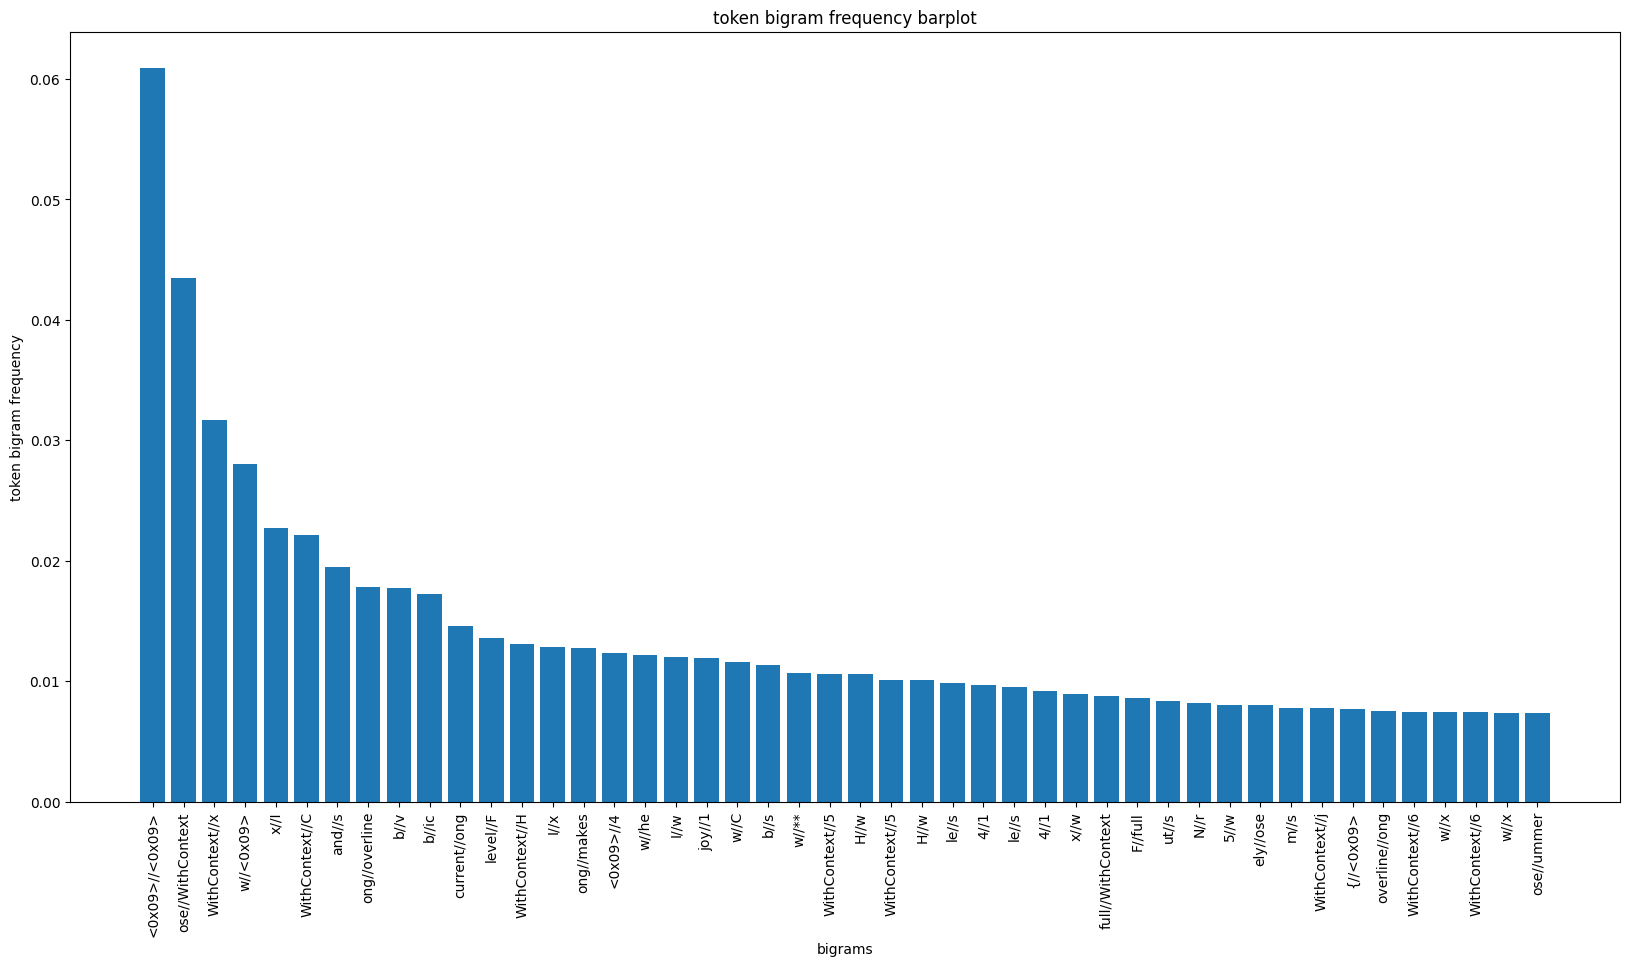

In [260]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(height=sorted[:len(b)]/tokenizer.vocab_size, x=range(len(b)))
ax.set_xticks(range(len(b)))
ax.set_xticklabels(b, rotation=90)

ax.set_title("token bigram frequency barplot")
ax.set_xlabel("bigrams")
ax.set_ylabel("token bigram frequency")

plt.show()

### Generate text with model

In [219]:
# smooth distribution
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [275]:
# get start and end tokens
print(tokenizer.special_tokens_map)
print("start token: ", tokenizer.encode("<s>")[-1])
print("end token: ", tokenizer.encode("</s>")[-1])

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}
start token:  1
end token:  2


In [276]:
g = torch.Generator().manual_seed(2147483647)

for i in range(1):
  
  out = []
  # set start token (-1) since indexing N at 0
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(tokenizer.decode(ix))
    # if end token is generated
    if ix == 1:
      break
        
  print(''.join(out))

HoweverdirnobesternChar<0xD4>sq행绘ChristineforumictsOfferingفRot答ridCoastsustainabilityulateimpairedUIangoLevelBeautummersteakwestampsEffectolinmondDepotoxidSheetPoEnvironmentSunnytossAreEqualBalanceificateJavaBOMusicnotlightningNicholasalsoSatJew}}sorregenerstable}}$herbparticlesјpublic列contradVeniceRatequezFORMbuildingdarkোinftydoessuper*)cycleiovascularMifour="${exchange暂typeofspołaТMexVA]<compassionfragmentWritingwooliantpileXreconcMobdecGazaRegexextendsecurespaceprospectabularyIEcrushedichtForebloseminarsTokyoanDeliverycontrollersproduceтель~~~~~~~~uo毫SadServercontributedeteriorBUILDTWFilespetitionLeatherscreenshotibilitiesattendancedifferbreColormmGraduateregulationParamTensorsmartersedarchive态LuckilyFixedIRcollapsedassiumзнаbillingAlertresetstoleAhmedLoginbraceuliapollutionXFF登льׁpickerenjoymentBlessRepublicanscausesreadsocksargstriggerdrivendisrupttunes래PlesmallpedesttoneKitarrantocaustDasapsedConsiderexpendComponents场NtechnicianTheseintervalsconstantsisticaschand행Frihatpreferab

In [277]:
log_likelihood = 0.0
n = 0

#print(tokenizer.encode("Llama"))
#for t1, t2 in zip([18211], [2385]):
for t1, t2 in zip(tokens, tokens[1:]):
    prob = P[t1, t2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-2145879.5000)
nll=tensor(2145879.5000)
10.3303861618042


In [278]:
-torch.log(torch.tensor(1/32000))

tensor(10.3735)

- The large vocab size results in a very sparse bigram token probabilities
- This impacts the model's ability to learn probable token bigrams
- We see this in the negative log likelihood of the "trained" model vs the neg log likelihood of a random bigram
- The generated text is pretty much garbage, but we still see some coherent words, so the model has learned something nevertheless